In [1]:
import pickle
from datetime import datetime

import math
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cross_validation import train_test_split

# Models
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import linear_model
from sklearn import ensemble
from sklearn import metrics
from sklearn.cross_validation import ShuffleSplit
#from sklearn.pipeline import Pipeline
#from sklearn.grid_search import GridSearchCV


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A helper function to get metrics
def get_metrics(y_truth, y_predicted, p_label, return_flag = False):
    confusion_matrix = metrics.confusion_matrix(y_truth, y_predicted, labels = [1,0])
    accuracy = round((metrics.accuracy_score(y_truth, y_predicted)), 2)
    precision = round((metrics.precision_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    recall = round((metrics.recall_score(y_truth, y_predicted, pos_label = p_label, average = 'binary')), 2)
    
    if(return_flag):
        return(pd.DataFrame([accuracy,precision,recall]).transpose())
    else:
        print ("Confusion Matrix:")
        print (confusion_matrix)
        print ()
        print ("Accuracy: %f;\nPrecision: %f;\nRecall: %f;" %(accuracy, precision, recall))


In [6]:
# Read in data
all_data_preprocessed_pkl = open("C:\\Users\\YWang\\Desktop\\plg\\4th meeting_0922\\104K_data_preprocessed.pkl","rb")
all_data = pickle.load(all_data_preprocessed_pkl)
all_data[['call','ex_tag']] = all_data[['call','ex_tag']].astype('int')

all_data[:3]

,id,call,ex_tag,txt
0,CTRL000000096,0,0,subject fw quality moves to utilize on your ...
1,CTRL000000097,0,0,subject schedule confirmation from guzman m...
2,CTRL000000099,0,0,subject emergency meeting from williams iii...


In [7]:
data_no_extag = all_data[all_data['ex_tag']==0]

print(data_no_extag.shape)
print("Positive %: ",sum(data_no_extag['call'])/data_no_extag.shape[0])
data_no_extag[:3]

(13418, 4)
Positive %:  0.15270532121


,id,call,ex_tag,txt
0,CTRL000000096,0,0,subject fw quality moves to utilize on your ...
1,CTRL000000097,0,0,subject schedule confirmation from guzman m...
2,CTRL000000099,0,0,subject emergency meeting from williams iii...


# Outline
1. RF and logistic regression as benchmark
2. **Explore Naive Bayes models**
3. **Compare model results (Excel)**
4. TakeAways

### 0. Create three versions of Bag-of-Words vectorization
1. txt_BINARY 

2. txt_FC 

3. txt_TFIDF

In [8]:
# timing - start
start_time = datetime.today()



# 1. BOW - Binary
vectorizer = CountVectorizer(encoding = 'utf-8-sig', stop_words = 'english', 
                             max_df = 0.85, max_features = 5000, ngram_range = (1, 1),
                             binary = True)
vectorizer.fit(data_no_extag['txt'])
txt_BINARY = vectorizer.transform(data_no_extag['txt'])

# timing
t1 = datetime.today() - start_time



# 2. BOW - Frequency count
vectorizer = CountVectorizer(encoding = 'utf-8-sig', stop_words = 'english', 
                             max_df = 0.85, max_features = 5000, ngram_range = (1, 1),
                             binary = False)
vectorizer.fit(data_no_extag['txt'])
txt_FC = vectorizer.transform(data_no_extag['txt'])

# timing
t2 = datetime.today() - t1 - start_time



# 3. BOW - TF-IDF
tfidf_transformer = TfidfTransformer(sublinear_tf = False, use_idf = True, norm = 'l2')
tfidf_transformer.fit(txt_FC)
txt_TFIDF = tfidf_transformer.transform(txt_FC)

# timing - for both BOW vectorizing and tfidf transformation
t3 = datetime.today() - t1 - start_time



# See what's it like
print (txt_TFIDF.shape)
print("Binary vecotrizing: ", t1)
print("Frequcency count vectorizing ", t2)
print("TFIDF vectorizing: ", t3)

(13418, 5000)
Binary vecotrizing:  0:00:49.708003
Frequcency count vectorizing  0:00:58.920875
TFIDF vectorizing:  0:00:59.166875


In [10]:
# Train test split for 3 vectorizations
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(txt_BINARY, data_no_extag['call'], test_size = 0.95, random_state = 1)
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(txt_FC, data_no_extag['call'], test_size = 0.95, random_state = 1)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(txt_TFIDF, data_no_extag['call'], test_size = 0.95, random_state = 1)

# QC - all y_train and y_test should be the same (controlled for random state)
sum(y_train_b.index == y_train_t.index)

670

In [11]:
X_train = [X_train_b, X_train_f, X_train_t]
X_test = [X_test_b, X_test_f, X_test_t]

RandomForest:


,Accuracy,Precision,Recall
Binary,0.93,0.98,0.55
Frequency Count,0.93,0.98,0.54
TFIDF,0.92,0.99,0.51


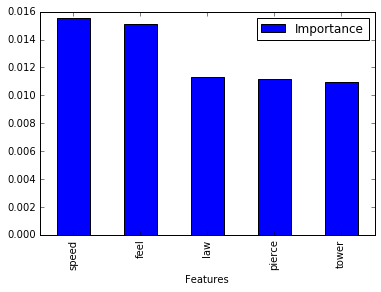

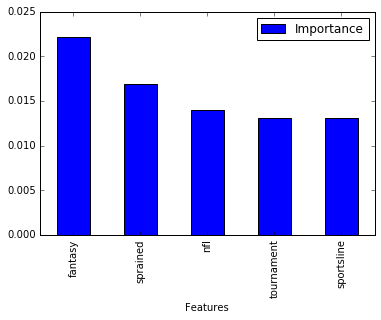

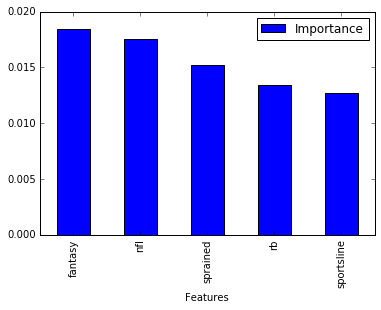

In [12]:
rf = ensemble.RandomForestClassifier(n_estimators = 200, min_samples_leaf = 1, max_features = 'sqrt', random_state = 1)
rf_metrics = pd.DataFrame()
for train, test in zip(X_train, X_test):
    rf.fit(train, y_train_b)
    y_pred = rf.predict(test)
    result_metrics = get_metrics(y_test_t, y_pred, p_label = 1, return_flag = True)
    
    rf_metrics = pd.concat([rf_metrics, result_metrics])
    
    feature_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                               "Importance": rf.feature_importances_
                              })
    feature_df.sort_values('Importance', ascending = False)[:5].plot(x = 'Features', y = 'Importance', kind='bar')

print("RandomForest:")
rf_metrics.columns = ['Accuracy', 'Precision','Recall']
rf_metrics.index = ['Binary', "Frequency Count", "TFIDF"]
rf_metrics

Logistic Regression:


,Accuracy,Precision,Recall
Binary,0.90,1.00,0.33
Frequency Count,0.90,0.98,0.35
TFIDF,0.88,1.00,0.24


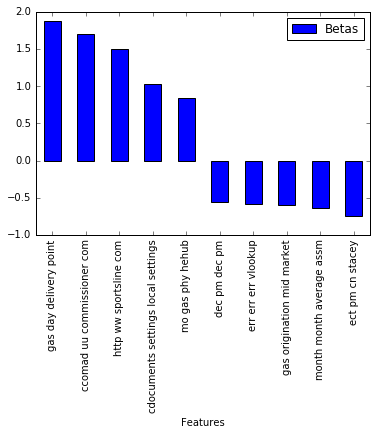

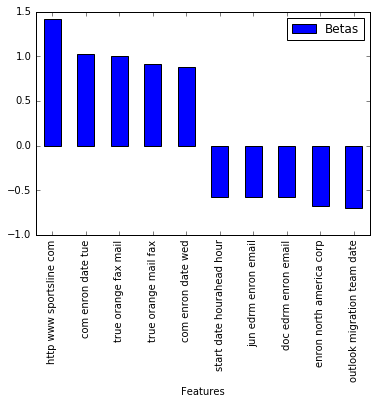

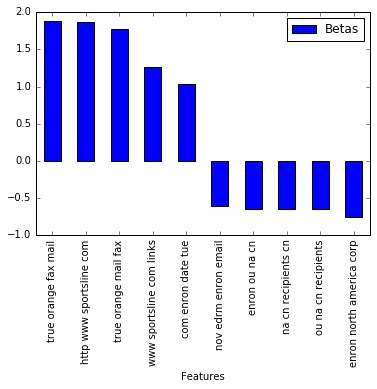

In [147]:
logit = linear_model.LogisticRegression()
logit_metrics = pd.DataFrame()
for train, test in zip(X_train, X_test):
    logit.fit(train, y_train_b)
    y_pred = logit.predict(test)
    result_metrics = get_metrics(y_test_t, y_pred, p_label = 1, return_flag = True)
    
    logit_metrics = pd.concat([logit_metrics, result_metrics])

    betas_df = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                             "Betas":logit.coef_[0]
                            })
    
    pos = betas_df.sort_values('Betas', ascending = False)[:5]
    neg = betas_df.sort_values('Betas', ascending = False)[-5:]
    pd.concat([pos,neg]).plot(x = 'Features', y = 'Betas', kind='bar')
    
print("Logistic Regression:")
logit_metrics.columns = ['Accuracy', 'Precision','Recall']
logit_metrics.index = ['Binary', "Frequency Count", "TFIDF"]
logit_metrics

In [99]:
t0 = datetime.today()

rf = ensemble.RandomForestClassifier(n_estimators = 200, min_samples_leaf = 1, max_features = 'sqrt', random_state = 1)
rf.fit(X_train_t, y_train_t)
y_pred_rf = pd.DataFrame(rf.predict(X_test_t), index = y_test_t.index)
get_metrics(y_test_t, y_pred_rf, p_label = 1)

print ("\n", datetime.today() - t0)

# Get class probability
y_prob_rf = pd.DataFrame(rf.predict_proba(X_test_t), index = y_test_t.index)

Confusion Matrix:
[[  995   962]
 [    6 10785]]

Accuracy: 0.920000;
Precision: 0.990000;
Recall: 0.510000;

 0:00:02.629200


In [114]:
rf_tfidf_result = pd.merge(y_pred_rf, y_prob_rf, left_index=True, right_index=True)
rf_tfidf_result.columns = ["rf_Predicted Label", "rf_P(Call=0)", "rf_P(Call=1)"]

In [148]:
t0 = datetime.today()

logit = linear_model.LogisticRegression()
logit.fit(X_train_t, y_train_t)
y_pred_l = pd.DataFrame(logit.predict(X_test_t), index = y_test_t.index)
get_metrics(y_test_t, y_pred_l, p_label = 1)

print ("\n", datetime.today() - t0)

# Get class probability
y_prob_l = pd.DataFrame(logit.predict_proba(X_test_t), index = y_test_t.index)

Confusion Matrix:
[[  465  1492]
 [    0 10791]]

Accuracy: 0.880000;
Precision: 1.000000;
Recall: 0.240000;

 0:00:00.070000


In [115]:
logit_tfidf_result = pd.merge(y_pred_l, y_prob_l, left_index=True, right_index=True)
logit_tfidf_result.columns = ["logit_Predicted Label", "logit_P(Call=0)", "logit_P(Call=1)"]

### Naive Bayes Classifiers
Assumption:
1. Occurence of one word is independent of occurence of other words ** -- Could be a good thing!**

Idea:

1. Docs are represented by combination of independent words; 
2. Given a certain word combo, what is the most possible class?
3. Predict Doc X belongs to class A if:

    **P(Doc X ∈ class A| word combo of Doc X) > P(Doc X ∈ class B| word combo of Doc X)**
    
4. P(Doc X ∈ class A| word combo of Doc X) is estimated by:  

    **P(word combo of Doc X|Doc X ∈ class A) * P(class A)   -- Bayes Rule**
     
5. P(word combo of Doc X|Doc X ∈ class A) is estimated by:

    **P(word 1 in Doc X|Doc X ∈ class A) * P(word 2 in Doc X|Doc X ∈ class A)...   -- Independent assumption**

Types: (assumes different distribution of P(**word i in Doc X** | **Doc X in class A**)

1. Bernoulli

2. Multinomial

3. Gaussian


#### 1. Bernoulli with binary BOW

In [80]:
t0 = datetime.today()

bnb = BernoulliNB(alpha = 0.01, fit_prior = True)
bnb.fit(X_train_b,y_train_b)                            # Use binary BOW
y_pred_bnb = pd.DataFrame(bnb.predict(X_test_b), index = y_test_t.index)
get_metrics(y_test_b, y_pred_bnb, p_label = 1)

print ("\n", datetime.today() - t0)

# Get Prob
y_prob_bnb = pd.DataFrame(bnb.predict_proba(X_test_b), index = y_test_t.index)

Confusion Matrix:
[[ 1058   899]
 [   29 10762]]

Accuracy: 0.930000;
Precision: 0.970000;
Recall: 0.540000;

 0:00:01.948400


In [69]:
# Most likely words in positive/negative class (in terms of frequency)
word_con_prob = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                              "P(w|call=0)":bnb.feature_log_prob_[0],
                              "P(w|call=1)":bnb.feature_log_prob_[1]
                             })

print("Most likely words in positive class:")
print(word_con_prob[["Features","P(w|call=1)"]].sort_values("P(w|call=1)", ascending = False)[:5])
print()
print("Most likely words in negative class:")
print(word_con_prob[["Features","P(w|call=0)"]].sort_values("P(w|call=0)", ascending = False)[:5])

Most likely words in positive class:
      Features  P(w|call=1)
1481  emission    -0.044556
4977        yg    -0.044556
1848    france    -0.055983
2158     hydro    -0.055983
2592    little    -0.055983

Most likely words in negative class:
        Features  P(w|call=0)
4977          yg    -0.219702
3481   procedure    -0.232717
1848      france    -0.241489
4475        tech    -0.245904
2591  litigation    -0.248119


In [116]:
bnb_binary_result = pd.merge(y_pred_bnb, y_prob_bnb, left_index=True, right_index=True)
bnb_binary_result.columns = ["bnb_Predicted Label", "bnb_P(Call=0)", "bnb_P(Call=1)"]

#### 2.1 Multinomial NB with BOW

In [76]:
t0 = datetime.today()

mnb = MultinomialNB(alpha = 1, class_prior = (0.85,0.15))
mnb.fit(X_train_f,y_train_f)                            # Use frequency count BOW
y_pred_mnb = pd.DataFrame(mnb.predict(X_test_f), index = y_test_t.index)
get_metrics(y_test_f, y_pred_mnb, p_label = 1)

print ("\n", datetime.today() - t0)

# Get Prob
y_prob_mnb = pd.DataFrame(mnb.predict_proba(X_test_f), index = y_test_t.index)

Confusion Matrix:
[[1890   67]
 [6446 4345]]

Accuracy: 0.490000;
Precision: 0.230000;
Recall: 0.970000;

 0:00:02.867600


In [68]:
# Most likely words in positive/negative class (in terms of frequency)
word_con_prob = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                              "P(w|call=0)":mnb.feature_log_prob_[0],
                              "P(w|call=1)":mnb.feature_log_prob_[1]
                             })

print("Most likely words in positive class:")
print(word_con_prob[["Features","P(w|call=1)"]].sort_values("P(w|call=1)", ascending = False)[:5])
print()
print("Most likely words in negative class:")
print(word_con_prob[["Features","P(w|call=0)"]].sort_values("P(w|call=0)", ascending = False)[:5])

Most likely words in positive class:
     Features  P(w|call=1)
4712  updated    -3.937533
1895     game    -4.420621
4874     week    -4.437396
4941       wr    -4.554945
1701  fantasy    -4.702773

Most likely words in negative class:
     Features  P(w|call=0)
4385      sum    -3.279289
593       cal    -3.413364
1904   gasgen    -4.113595
1506   energy    -4.376108
1902      gas    -4.494281


In [120]:
mnb_fc_result = pd.merge(y_pred_mnb, y_prob_mnb, left_index=True, right_index=True)
mnb_fc_result.columns = ["mnb_Predicted Label", "mnb_P(Call=0)", "mnb_P(Call=1)"]

#### 2.2 Multinomial NB with tf-idf 

In [143]:
t0 = datetime.today()
mnb2 = MultinomialNB(alpha = 1, class_prior = (0.85,0.15))
mnb2.fit(X_train_t,y_train_t)                            # Use TF-IDF BOW
y_pred_mnb2 = pd.DataFrame(mnb2.predict(X_test_t), index = y_test_t.index)
get_metrics(y_test_t, y_pred_mnb2, p_label = 1)

print ("\n", datetime.today() - t0)

# Get Prob
y_prob_mnb2 = pd.DataFrame(mnb2.predict_proba(X_test_t), index = y_test_t.index)

Confusion Matrix:
[[  809  1148]
 [   13 10778]]

Accuracy: 0.910000;
Precision: 0.980000;
Recall: 0.410000;

 0:00:01.983000


In [70]:
# Most likely words in positive/negative class (in terms of frequency)
word_con_prob = pd.DataFrame({"Features": vectorizer.get_feature_names(), 
                              "P(w|call=0)":mnb2.feature_log_prob_[0],
                              "P(w|call=1)":mnb2.feature_log_prob_[1]
                             })

print("Most likely words in positive class:")
print(word_con_prob[["Features","P(w|call=1)"]].sort_values("P(w|call=1)", ascending = False)[:5])
print()
print("Most likely words in negative class:")
print(word_con_prob[["Features","P(w|call=0)"]].sort_values("P(w|call=0)", ascending = False)[:5])

Most likely words in positive class:
        Features  P(w|call=1)
4712     updated    -6.175687
1701     fantasy    -6.536642
1895        game    -6.565785
4941          wr    -6.628878
4250  sportsline    -6.801667

Most likely words in negative class:
          Features  P(w|call=0)
329    attribution    -5.228434
4995            zl    -5.228913
4477  technologies    -5.246996
805             cn    -5.783251
2142          http    -5.792671


In [117]:
mnb_tfidf_result = pd.merge(y_pred_mnb2, y_prob_mnb2, left_index=True, right_index=True)
mnb_tfidf_result.columns = ["mnb_tfidf_Predicted Label", "mnb_tfidf_P(Call=0)", "mnb_tfidf_P(Call=1)"]

### Merge all result together and compare

In [133]:
temp = pd.concat([rf_tfidf_result, logit_tfidf_result, bnb_binary_result, mnb_fc_result,mnb_tfidf_result],axis = 1)
temp = pd.concat([data_no_extag, temp], axis = 1, join = 'outer')
print(temp[:3])

temp.to_csv("output_092116.txt", header = True, index = False, encoding = 'utf-8')

                  id  call  ex_tag  \
94738  CTRL000392942     0       0   
67935  CTRL000258617     0       0   
91131  CTRL000354062     0       0   

                                                     txt  rf_Predicted Label  \
94738  subject  eb      sheri thomas date  mon     ja...                   0   
67935  subject  fw  market update from  deffner  jose...                   0   
91131  civic club news by kathleen gay  those of us w...                   0   

       rf_P(Call=0)  rf_P(Call=1)  logit_Predicted Label  logit_P(Call=0)  \
94738          0.99          0.01                      0         0.949348   
67935          0.89          0.11                      0         0.935431   
91131          0.83          0.17                      0         0.905110   

       logit_P(Call=1)  bnb_Predicted Label  bnb_P(Call=0)  bnb_P(Call=1)  \
94738         0.050652                    0            1.0   1.422082e-15   
67935         0.064569                    0            1.0   1.

### Take aways and next steps:
#### 1. Accuracy score is not the end of the story

#### 2. Naive Bayes independent assumption will favor the class with stronger word dependency -- could play to our favor!

#### 3. Different models are good/poor at different things; ideas worth trying:


    (1) Let them vote on predicted labels / pick out predictions each of model is most confident about
    
    (2) Let them vote on choice of features
    
    (3) When training set is limited, we can use the most confident result from one model to train another model